In [1]:
import carla
import random
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Connect to the CARLA server
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)

Vehicle spawned successfully!
Spectator camera set to follow the vehicle.
RADAR sensor attached to the vehicle.
Simulation stopped.
RADAR sensor and vehicle destroyed.


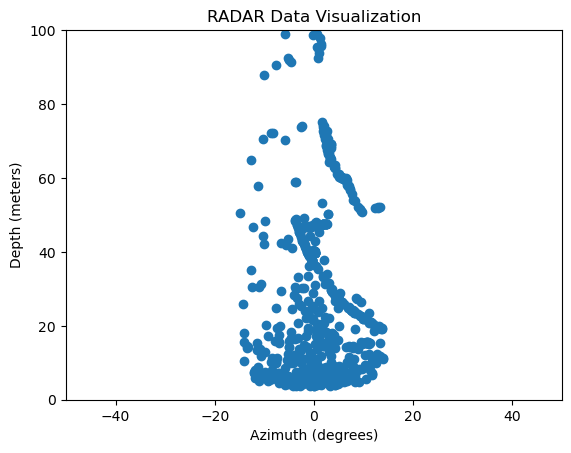

In [3]:
# Connect to the CARLA server
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)

# Get the world object
world = client.get_world()

# Set up the Traffic Manager
traffic_manager = client.get_trafficmanager()
traffic_manager.set_global_distance_to_leading_vehicle(2.0)  # Set a safe distance
traffic_manager.set_random_device_seed(0)  # Set a seed for reproducibility

# Get the blueprint library
bp_lib = world.get_blueprint_library()

# Get spawn points
spawn_points = world.get_map().get_spawn_points()

# Spawn a vehicle
vehicle_bp = bp_lib.find('vehicle.lincoln.mkz')  # Ensure this blueprint exists
vehicle = world.try_spawn_actor(vehicle_bp, random.choice(spawn_points))

if vehicle is not None:
    print("Vehicle spawned successfully!")
else:
    print("Failed to spawn vehicle.")

# Set the vehicle to autopilot mode
vehicle.set_autopilot(True, traffic_manager.get_port())

# Set the spectator camera to follow the vehicle
spectator = world.get_spectator()

# Define the camera transform relative to the vehicle
camera_offset = carla.Location(x=-4, z=2.5)  # Adjust these values as needed
vehicle_transform = vehicle.get_transform()

# Calculate the camera transform
camera_transform = carla.Transform(vehicle_transform.location + camera_offset, vehicle_transform.rotation)
spectator.set_transform(camera_transform)

print("Spectator camera set to follow the vehicle.")

# Add a RADAR sensor
radar_bp = bp_lib.find('sensor.other.radar')

# Configure RADAR attributes
radar_bp.set_attribute('horizontal_fov', '30')  # Field of view in degrees
radar_bp.set_attribute('vertical_fov', '30')
radar_bp.set_attribute('range', '100')  # Detection range in meters
radar_bp.set_attribute('points_per_second', '15000')  # Resolution

# Attach the RADAR to the vehicle
radar_location = carla.Location(x=2.0, z=1.0)  # Position on the vehicle
radar_rotation = carla.Rotation(pitch=0, yaw=0, roll=0)
radar_transform = carla.Transform(radar_location, radar_rotation)
radar = world.spawn_actor(radar_bp, radar_transform, attach_to=vehicle)

print("RADAR sensor attached to the vehicle.")

# Initialize Matplotlib for RADAR visualization
plt.ion()
fig, ax = plt.subplots()
scatter = ax.scatter([], [])
ax.set_xlim(-50, 50)  # Azimuth range
ax.set_ylim(0, 100)   # Depth range
ax.set_xlabel('Azimuth (degrees)')
ax.set_ylabel('Depth (meters)')
ax.set_title('RADAR Data Visualization')

# Define a callback to process RADAR data
def radar_callback(data):
    # Convert raw RADAR data to a numpy array
    points = np.frombuffer(data.raw_data, dtype=np.dtype('f4'))
    points = np.reshape(points, (len(data), 4))  # Each point has 4 values: velocity, azimuth, altitude, depth

    # Extract azimuth and depth for visualization
    azimuth = np.degrees(points[:, 1])  # Convert azimuth from radians to degrees
    depth = points[:, 3]  # Depth in meters

    # Update the scatter plot
    scatter.set_offsets(np.column_stack((azimuth, depth)))
    fig.canvas.flush_events()

# Listen to RADAR data
radar.listen(radar_callback)

# Run the simulation
try:
    while True:
        # Move the spectator camera to follow the vehicle
        vehicle_transform = vehicle.get_transform()
        camera_transform = carla.Transform(vehicle_transform.location + camera_offset, vehicle_transform.rotation)
        spectator.set_transform(camera_transform)

        # Tick the simulation
        world.tick()
        time.sleep(0.1)  # Add a small delay to avoid overloading the CPU

except KeyboardInterrupt:
    print("Simulation stopped.")

finally:
    # Destroy the RADAR sensor and vehicle
    if radar.is_alive:
        radar.destroy()
    if vehicle.is_alive:
        vehicle.destroy()
    print("RADAR sensor and vehicle destroyed.")